In [19]:
# Plot project search history
import json
import neuralparticles.tools.plot as plot
from pathlib import Path
from neuralparticles.tensorflow.tools.hyper_parameter import HyperParameter, ValueType, SearchType
from ast import literal_eval as make_tuple
from collections import namedtuple
import os

In [20]:
# plot functions
def plot_history(histories, title, path):
    # evaluate search history, do plots etc
    #title = "LSTM Loss (" + ", ".join([i.name for i in param_team]) + ")"
    #selected_params = '-'.join([i.name for i in param_team])
    # plot the histories
    lstm_history_plotter = plot.Plotter()
    lstm_history_plotter.plot_multi_loss_history(histories, highlight_best_count=3, title=title)
    lstm_history_plotter.show()
    lstm_history_plotter.save_figures(path, "history", "svg")

# https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html
# only supports two hyperparameters
def plot_scatter(histories, param_team, title, path):
    lstm_history_plotter = plot.Plotter()
    lstm_history_plotter.plot_multi_loss_scatter(histories, param_team, highlight_best_count=3, title=title)
    lstm_history_plotter.show()
    lstm_history_plotter.save_figures(path, "scatter", "svg")

In [21]:
def evaluate_search(search_path):
    print("\n============================================================================================")
    print("Evaluating '{}'".format(Path(search_path).absolute()))
    
    # load arguments.json and search_hist.json
    assert Path(search_path).exists(), "Project path '{}' not found.".format(search_path)
    if Path(search_path+"search_hist.json").exists() == False:
        print("search_hist.json not found!")
        return

    # load arguments
    args = None
    argument_file = search_path + "call.txt"
    with open(argument_file) as f:
        args = f.read().split(" ")[1:]

    i=0
    param_team = []
    while("hyper%d"%i in args):
        hyper_par = args[args.index("hyper%d"%i)+1]
        i += 1
        param_team.append(HyperParameter.parse(hyper_par))

    # load history
    histories = None
    history_file = search_path + "search_hist.json"
    with open(history_file) as f:
        histories = json.load(f)
        histories = dict((make_tuple(key), value) for (key, value) in histories.items())

    # plot the history
    plot_history(histories, "Metrics", search_path)
    plot_scatter(histories, param_team, "Scatter", search_path)
    # best values
    best_entry = None
    best_val = float("inf")
    for parameter, hist in histories.items():
        for metric, value in hist.items():
            if "val_loss" == metric and value[-1] < best_val:
                best_val = value[-1]
                best_entry = (parameter,)
                for met, val in hist.items():
                    best_entry += (met, val[-1])

    print("Best Entry: {} -> {}".format(best_entry[0], str(best_entry[1:]) ))


Evaluating '/home/prantl/Projects/NeuralParticles/sanity_check/tmp/2018-07-19_10-47-12'


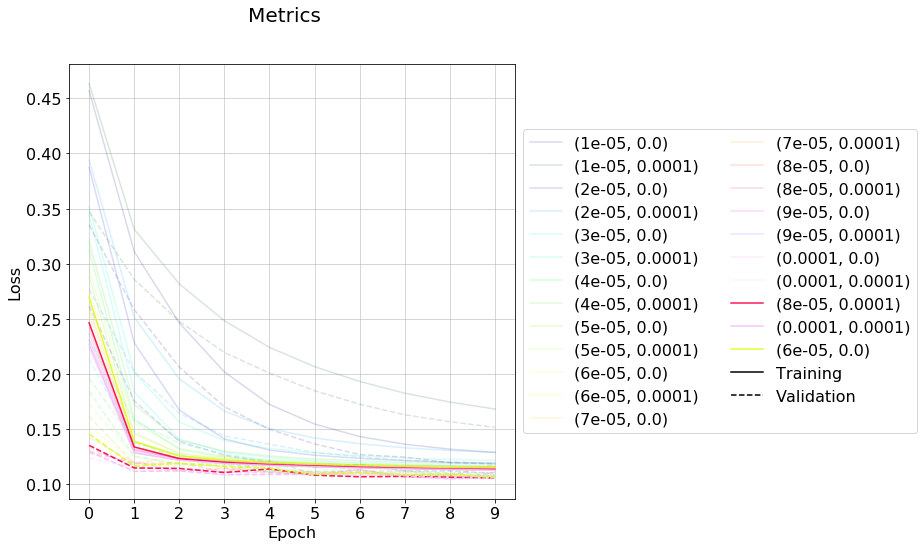

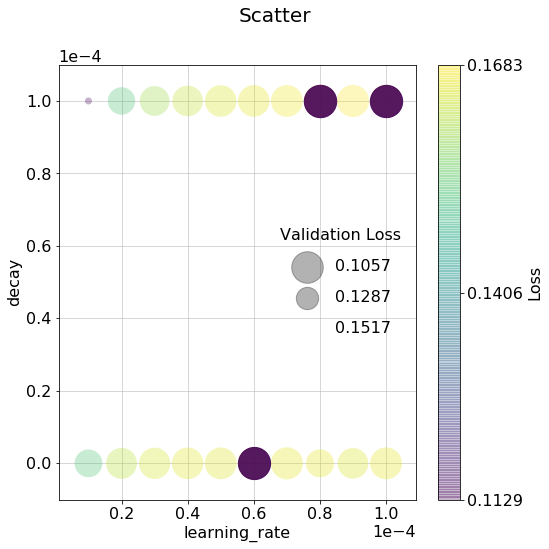

Best Entry: (8e-05, 0.0001) -> ('val_loss', 0.10568127238015648, 'val_masked_coords_loss', 0.10324794959639386, 'val_truncation_2_loss', 0.0021924008064571053, 'loss', 0.1136127049089146, 'masked_coords_loss', 0.10911050871821773, 'truncation_2_loss', 0.004255006012908)


In [23]:
# start the search
project_path = "./sanity_check/tmp/"
folder_name = "2018-07-19_10-47-12" #"search/AE"

if folder_name:
    evaluate_search(project_path+folder_name+"/")
else:
    # find all subfolders and evaluate search history
    filenames = os.listdir (project_path)
    for filename in filenames:
        joined_name = os.path.join(project_path, filename)
        if os.path.isdir(joined_name):
            evaluate_search(joined_name+"/")